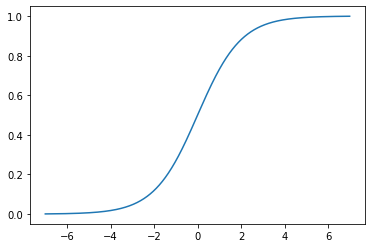

In [62]:
from matplotlib import pyplot as plt
import numpy as np
from math import exp
from PIL import Image
import sklearn


t = np.arange(-7, 7, 0.01)

# red dashes, blue squares and green triangles
plt.plot(t, 1/(1+(np.exp(-t))))
plt.savefig('logistic.png')


Hi! This is a python notebook demoing using Logistic Regression for sentiment analysis on the public IMDB movie reviews dataset.

Idea creds:
https://towardsdatascience.com/sentiment-analysis-with-python-part-1-5ce197074184

Dataset is available at:
https://www.kaggle.com/iarunava/imdb-movie-reviews-dataset

  * What is logistic regression and what is it used for?  
      * Go-to for binary classification
         * Binary classification is useful when we have 2 choices(b/w, y/n, good/bad)
         * Not so useful when we don't have discrete choices ie. pretty good
      * Like many machine learning techniques it was stolen from statistics
          * At its core it uses the logistic function aka the sigmoid function
          * Logistic function takes any real valued number and maps it between 0 and 1  
          # $\frac{1}{1+e^{-x}} \quad \forall x \in \mathbb{R}$
          
          
          

In [36]:
import sklearn
print(sklearn.__version__)

0.21.2


In [37]:
reviews_train = []
for line in open('full_train.txt', 'r'):
    reviews_train.append(line.strip())
    
reviews_test = []
for line in open('full_test.txt', 'r'):
    reviews_test.append(line.strip())

In [38]:
print(reviews_train[:100])

['Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High\'s satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers\' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I\'m here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn\'t!', 'Homelessness (or Houselessness as George Carlin stated) has been an issue for years but never a plan to help those on the street that were once considered human who did everything from

In [39]:
import re

REPLACE_NO_SPACE = re.compile("[.;:!\'?,\"()\[\]]")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")

def preprocess_reviews(reviews):
    reviews = [REPLACE_NO_SPACE.sub("", line.lower()) for line in reviews]
    reviews = [REPLACE_WITH_SPACE.sub(" ", line) for line in reviews]
    
    return reviews

reviews_train_clean = preprocess_reviews(reviews_train)
reviews_test_clean = preprocess_reviews(reviews_test)

In [40]:
print(reviews_train_clean[:100])

['bromwell high is a cartoon comedy it ran at the same time as some other programs about school life such as teachers my 35 years in the teaching profession lead me to believe that bromwell highs satire is much closer to reality than is teachers the scramble to survive financially the insightful students who can see right through their pathetic teachers pomp the pettiness of the whole situation all remind me of the schools i knew and their students when i saw the episode in which a student repeatedly tried to burn down the school i immediately recalled  at  high a classic line inspector im here to sack one of your teachers student welcome to bromwell high i expect that many adults of my age think that bromwell high is far fetched what a pity that it isnt', 'homelessness or houselessness as george carlin stated has been an issue for years but never a plan to help those on the street that were once considered human who did everything from going to school work or vote for the matter most 

In [41]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(binary=True)
cv.fit(reviews_train_clean)
X = cv.transform(reviews_train_clean)
X_test = cv.transform(reviews_test_clean)



In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

target = [1 if i < 12500 else 0 for i in range(25000)]

X_train, X_val, y_train, y_val = train_test_split(
    X, target, train_size = 0.75
)

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, lr.predict(X_val))))

/Users/skandera/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy for C=0.01: 0.87344
Accuracy for C=0.05: 0.88368
Accuracy for C=0.25: 0.87872
Accuracy for C=0.5: 0.87536
Accuracy for C=1: 0.87312


In [43]:
final_model = LogisticRegression(C=0.05)
final_model.fit(X, target)
print ("Final Accuracy: %s" 
       % accuracy_score(target, final_model.predict(X_test)))

Final Accuracy: 0.88152


In [44]:
#TODO add vectorization here


test_string="I hated that movie! It was scary."
print(final_model.predict(test_string))

ValueError: Expected 2D array, got scalar array instead:
array=I hated that movie! It was scary..
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
feature_to_coef = {
    word: coef for word, coef in zip(
        cv.get_feature_names(), final_model.coef_[0]
    )
}
for best_positive in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1], 
    reverse=True)[:5]:
    print (best_positive)
    
for best_negative in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1])[:5]:
    print (best_negative)